# LSTM Model for Crowd
-   For someone that is traveling in the next 14 days to 3 months 
-   Use Open meto API to get weather for the next 14 days to 3 months for testing
-   Use Feature Embedding for larger catagorical columns
    -   10 cat's 3-5, 50 cat's 7-8, 100 cat's 10.... 7-8 Emb Layers

In [76]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler,RobustScaler 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder as ohe
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional,Embedding
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from datetime import datetime,timedelta,date
from dateutil import parser
import openmeteo_requests
import requests_cache
from retry_requests import retry

### Loading Data

In [96]:
Auck_peds = pd.read_csv('data_weather/Final/Auckland_Pedestrian_Hourly.csv')
Dub_peds = pd.read_csv('data_weather/Final/Dublin_Pedestrian_Hourly.csv')
combine = pd.concat([Auck_peds,Dub_peds],ignore_index=True,axis='index')
combine['Date'] = combine['Date'].apply(lambda x: pd.to_datetime(x))
display(combine['Date'].head(1))
display(combine.head(2))
display(combine.tail(2))
display(combine.dtypes.to_frame().T)

0   2021-03-23
Name: Date, dtype: datetime64[ns]

,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,Avg_Daily_Pedestrian_Count,Holiday,Weather_Temperature_Avg,Weather_Wind_Speed_Avg,Weather_Precipitation_Sum,Weather_Relative_Humidity_Avg
0,New Zealand,Auckland,NZAUK_3,Mount Eden (Maungawhau),Volcanic Cone,Nature & Outdoor,-36.8793,174.7656,2021-03-23,23880.0,0.0,16.736584,7.487225,0.0,66.083336
1,New Zealand,Auckland,NZAUK_3,Mount Eden (Maungawhau),Volcanic Cone,Nature & Outdoor,-36.8793,174.7656,2021-03-24,25336.0,0.0,16.897001,7.100323,0.0,70.208336


,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,Avg_Daily_Pedestrian_Count,Holiday,Weather_Temperature_Avg,Weather_Wind_Speed_Avg,Weather_Precipitation_Sum,Weather_Relative_Humidity_Avg
16343,Ireland,Dublin,IRDUB_4,Temple Bar District,Entertainment District,Urban & Leisure,53.3457,-6.2665,2025-11-04,236487.0,0.0,14.722248,8.13,22.4,91.208336
16344,Ireland,Dublin,IRDUB_4,Temple Bar District,Entertainment District,Urban & Leisure,53.3457,-6.2665,2025-11-05,150056.0,0.0,15.226415,9.03,7.8,89.625000


,Country,City,Location_ID,Location_Name,Type_of_Attraction,Attraction_Category,Latitude,Longitude,Date,Avg_Daily_Pedestrian_Count,Holiday,Weather_Temperature_Avg,Weather_Wind_Speed_Avg,Weather_Precipitation_Sum,Weather_Relative_Humidity_Avg
0,object,object,object,object,object,object,float64,float64,datetime64[ns],float64,float64,float64,float64,float64,float64


### Open meto API 

In [21]:
# Setup the Open-Meteo API client with cache and retry on error # <--- this is from Open Meteo Api Docs
cache_session = requests_cache.CachedSession('.rnnlstmcache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [22]:
def Weather_Requester(lat:float,long:float,DepDate:date) -> list:
    print(DepDate.month)
    time = (DepDate - date.today()).days
    print(time)
    if time <= 14:
        url = "https://api.open-meteo.com/v1/forecast"
        params = {"latitude": lat,"longitude": long,"forecast_days": time,"hourly": ["temperature_2m", "precipitation", "wind_speed_10m"]}
        response = openmeteo.weather_api(url,params=params)
        hly = response[0].Hourly()
        T = float(hly.Variables(0).ValuesAsNumpy()[-1]).__round__(6)
        P = float(hly.Variables(1).ValuesAsNumpy()[-1]).__round__(6)
        W = float(hly.Variables(2).ValuesAsNumpy()[-1]).__round__(6)
    if time > 14 and time <= 45:
        url = "https://seasonal-api.open-meteo.com/v1/seasonal"
        params = {"latitude": lat,"longitude": long,"daily": ["temperature_2m_mean", "precipitation_sum", "wind_speed_10m_mean"],"forecast_days": 45}
        response = openmeteo.weather_api(url,params=params)
        dly = response[0].Daily()
        T = float(dly.Variables(0).ValuesAsNumpy()[time-1]).__round__(6)
        P = float(dly.Variables(1).ValuesAsNumpy()[time-1]).__round__(6)
        W = float(dly.Variables(2).ValuesAsNumpy()[time-1]).__round__(6)
    try:
        return [T,P,W]
    except:
        return []

# Weather_Requester(53.34,-6.25,parser.parse("2025-12-14").date())

### Feature Encoding
-   Cyclical Enc on time for day,month
-   Location Enc or indexing
-   Country,City,Location_Name,Type_of_Attraction,Attraction_Category -> pushed into embedded layer

In [23]:
dfLocDex = combine.copy()
dfLocDex['Location_Index'] = dfLocDex['Location_ID'].astype('category').cat.codes
dfCylEnc = dfLocDex.copy()

Season = {'Winter':1,'Spring':2,'Summer':3,'Fall':4}
dfCylEnc['Month_Sin'] = np.sin(2 * np.pi * dfCylEnc['Date'].dt.month / 12)
dfCylEnc['Month_Cos'] = np.cos(2 * np.pi * dfCylEnc['Date'].dt.month / 12)
dfCylEnc['Day_Sin']   = np.sin(2 * np.pi * dfCylEnc['Date'].dt.dayofweek / 7)
dfCylEnc['Day_Cos']   = np.cos(2 * np.pi * dfCylEnc['Date'].dt.dayofweek / 7)
dfCylEnc.describe(include='all').T.round(3)

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Country,16345,2,New Zealand,8265,NaN,NaN,NaN,NaN,NaN,NaN,NaN
City,16345,2,Auckland,8265,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Location_ID,16345,10,NZAUK_3,1653,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Location_Name,16345,10,Mount Eden (Maungawhau),1653,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Type_of_Attraction,16345,10,Volcanic Cone,1653,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Attraction_Category,16345,4,Culture & History,6501,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Latitude,16345.0,NaN,NaN,NaN,7.737095,-36.8793,-36.8485,-36.807,53.3429,53.3457,45.093494
Longitude,16345.0,NaN,NaN,NaN,85.305486,-6.286,-6.2665,174.7588,174.7656,175.075,90.544383
Date,16345,NaN,NaN,NaN,2023-05-10 08:23:03.175282944,2021-01-01 00:00:00,2022-03-26 00:00:00,2023-05-08 00:00:00,2024-06-20 00:00:00,2025-11-05 00:00:00,NaN
Avg_Daily_Pedestrian_Count,16345.0,NaN,NaN,NaN,176342.161762,2936.0,100530.0,145906.0,249148.0,535859.0,113765.869284


Applying Integer Encoding on Type_of_Attraction and Attraction_Category to then drop them after

In [86]:
dfle = dfCylEnc.copy()
dfle['Country_Encoded'] = dfle['Country'].astype("category").cat.codes
dfle['City_Encoded'] = dfle['City'].astype("category").cat.codes
dfle['Location_Name_Encoded'] = dfle['Location_Name'].astype("category").cat.codes
dfle["Type_of_Attraction_Encoded"] = dfle["Type_of_Attraction"].astype("category").cat.codes
dfle["Attraction_Category_Encoded"] = dfle["Attraction_Category"].astype("category").cat.codes
dfle = dfle.drop(columns=['Country','City','Location_Name','Type_of_Attraction','Attraction_Category','Latitude','Longitude'])
dfle.describe(include='all').T.round(3)

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Location_ID,16345,10,NZAUK_3,1653,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,16345,NaN,NaN,NaN,2023-05-10 08:23:03.175282944,2021-01-01 00:00:00,2022-03-26 00:00:00,2023-05-08 00:00:00,2024-06-20 00:00:00,2025-11-05 00:00:00,NaN
Avg_Daily_Pedestrian_Count,16345.0,NaN,NaN,NaN,176342.161762,2936.0,100530.0,145906.0,249148.0,535859.0,113765.869284
Holiday,16345.0,NaN,NaN,NaN,0.031508,0.0,0.0,0.0,0.0,1.0,0.174692
Weather_Temperature_Avg,16345.0,NaN,NaN,NaN,13.408068,-1.961833,10.531083,13.716165,16.742998,25.539335,4.543612
Weather_Wind_Speed_Avg,16345.0,NaN,NaN,NaN,13.905701,1.912203,8.924145,12.680945,17.88,52.5795,6.546513
Weather_Precipitation_Sum,16345.0,NaN,NaN,NaN,2.934206,0.0,0.0,0.4,2.9,128.70001,6.601175
Weather_Relative_Humidity_Avg,16345.0,NaN,NaN,NaN,78.882501,46.208332,73.416664,79.291664,84.958336,98.80872,8.226936
Location_Index,16345.0,NaN,NaN,NaN,4.528296,0.0,2.0,5.0,7.0,9.0,2.87223
Month_Sin,16345.0,NaN,NaN,NaN,0.010084,-1.0,-0.5,0.0,0.866025,1.0,0.70927


array([[<Axes: title={'center': 'Avg_Daily_Pedestrian_Count'}>,
        <Axes: title={'center': 'Holiday'}>],
       [<Axes: title={'center': 'Weather_Temperature_Avg'}>,
        <Axes: title={'center': 'Weather_Wind_Speed_Avg'}>],
       [<Axes: title={'center': 'Weather_Precipitation_Sum'}>,
        <Axes: title={'center': 'Weather_Relative_Humidity_Avg'}>]],
      dtype=object)

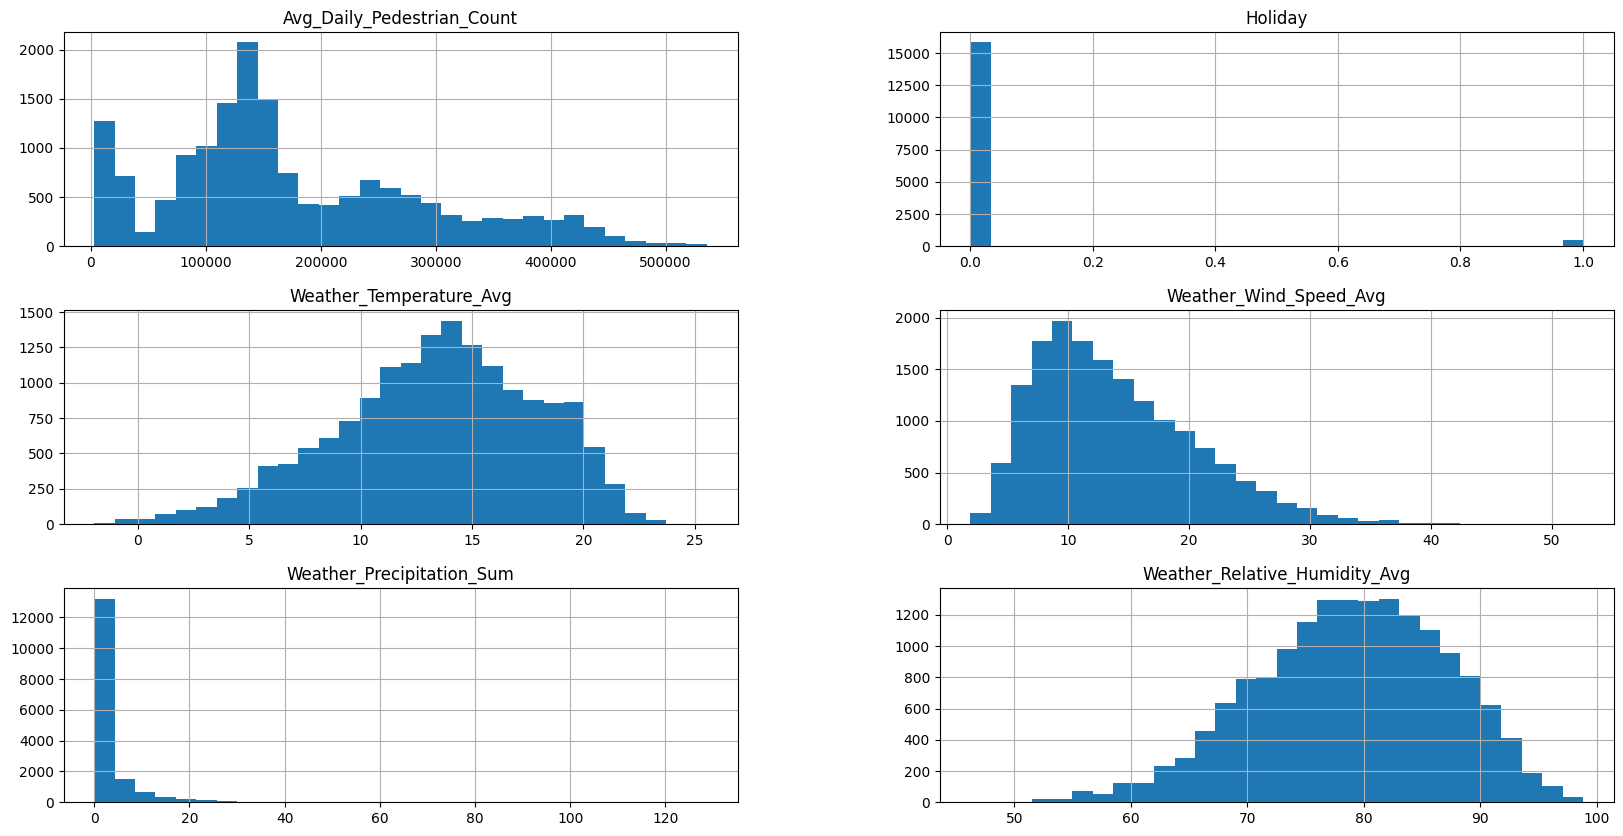

In [87]:
dfle.iloc[:,2:8].hist(figsize=(20,10),bins=30)

### Perfoming VIF to determine high or low correlations

In [79]:
vifTmp = dfle._get_numeric_data()#This line will drop non-numeric cols
xVif = dfle.iloc[:,2:].drop('Avg_Daily_Pedestrian_Count',axis=1)

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(xVif.values, i) for i in range(xVif.shape[1])]
vif['features'] = xVif.columns
vif.sort_values('VIF Factor')

,VIF Factor,features
8,1.001017,Day_Sin
9,1.016297,Day_Cos
6,1.018114,Month_Sin
0,1.023144,Holiday
7,1.043420,Month_Cos
2,1.197301,Weather_Wind_Speed_Avg
4,1.283799,Weather_Relative_Humidity_Avg
3,1.303498,Weather_Precipitation_Sum
1,1.410133,Weather_Temperature_Avg
14,1.441589,Attraction_Category_Encoded


### Try droping columns based on VIF that heavily correlates with Avg_Daily_Pedestrian_Count traget column 

In [80]:
dfle = dfle.drop(columns=['City_Encoded','Country_Encoded','Location_Index'],axis='columns')
dfle.describe(include='all').T.round(3)

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Location_ID,16345,10,NZAUK_3,1653,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,16345,NaN,NaN,NaN,2023-05-10 08:23:03.175282944,2021-01-01 00:00:00,2022-03-26 00:00:00,2023-05-08 00:00:00,2024-06-20 00:00:00,2025-11-05 00:00:00,NaN
Avg_Daily_Pedestrian_Count,16345.0,NaN,NaN,NaN,176342.161762,2936.0,100530.0,145906.0,249148.0,535859.0,113765.869284
Holiday,16345.0,NaN,NaN,NaN,0.031508,0.0,0.0,0.0,0.0,1.0,0.174692
Weather_Temperature_Avg,16345.0,NaN,NaN,NaN,13.408068,-1.961833,10.531083,13.716165,16.742998,25.539335,4.543612
Weather_Wind_Speed_Avg,16345.0,NaN,NaN,NaN,13.905701,1.912203,8.924145,12.680945,17.88,52.5795,6.546513
Weather_Precipitation_Sum,16345.0,NaN,NaN,NaN,2.934206,0.0,0.0,0.4,2.9,128.70001,6.601175
Weather_Relative_Humidity_Avg,16345.0,NaN,NaN,NaN,78.882501,46.208332,73.416664,79.291664,84.958336,98.80872,8.226936
Month_Sin,16345.0,NaN,NaN,NaN,0.010084,-1.0,-0.5,0.0,0.866025,1.0,0.70927
Month_Cos,16345.0,NaN,NaN,NaN,-0.039305,-1.0,-0.866025,-0.0,0.5,1.0,0.703811


### Scaling Data

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Location_ID,16345,10,NZAUK_3,1653,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Date,16345,NaN,NaN,NaN,2023-05-10 08:23:03.175282944,2021-01-01 00:00:00,2022-03-26 00:00:00,2023-05-08 00:00:00,2024-06-20 00:00:00,2025-11-05 00:00:00,NaN
Avg_Daily_Pedestrian_Count,16345.0,NaN,NaN,NaN,0.325387,0.0,0.18313,0.268275,0.462003,1.0,0.213475
Holiday,16345.0,NaN,NaN,NaN,0.031508,0.0,0.0,0.0,0.0,1.0,0.174692
Weather_Temperature_Avg,16345.0,NaN,NaN,NaN,0.558882,0.0,0.454269,0.570085,0.680147,1.0,0.165215
Weather_Wind_Speed_Avg,16345.0,NaN,NaN,NaN,0.236711,0.0,0.138392,0.212538,0.31515,1.0,0.129206
Weather_Precipitation_Sum,16345.0,NaN,NaN,NaN,0.022799,0.0,0.0,0.003108,0.022533,1.0,0.051291
Weather_Relative_Humidity_Avg,16345.0,NaN,NaN,NaN,0.621177,0.0,0.517265,0.628956,0.736687,1.0,0.156404
Location_Index,16345.0,NaN,NaN,NaN,0.503144,0.0,0.222222,0.555556,0.777778,1.0,0.319137
Month_Sin,16345.0,NaN,NaN,NaN,0.505042,0.0,0.25,0.5,0.933013,1.0,0.354635


array([[<Axes: title={'center': 'Avg_Daily_Pedestrian_Count'}>,
        <Axes: title={'center': 'Holiday'}>],
       [<Axes: title={'center': 'Weather_Temperature_Avg'}>,
        <Axes: title={'center': 'Weather_Wind_Speed_Avg'}>],
       [<Axes: title={'center': 'Weather_Precipitation_Sum'}>,
        <Axes: title={'center': 'Weather_Relative_Humidity_Avg'}>]],
      dtype=object)

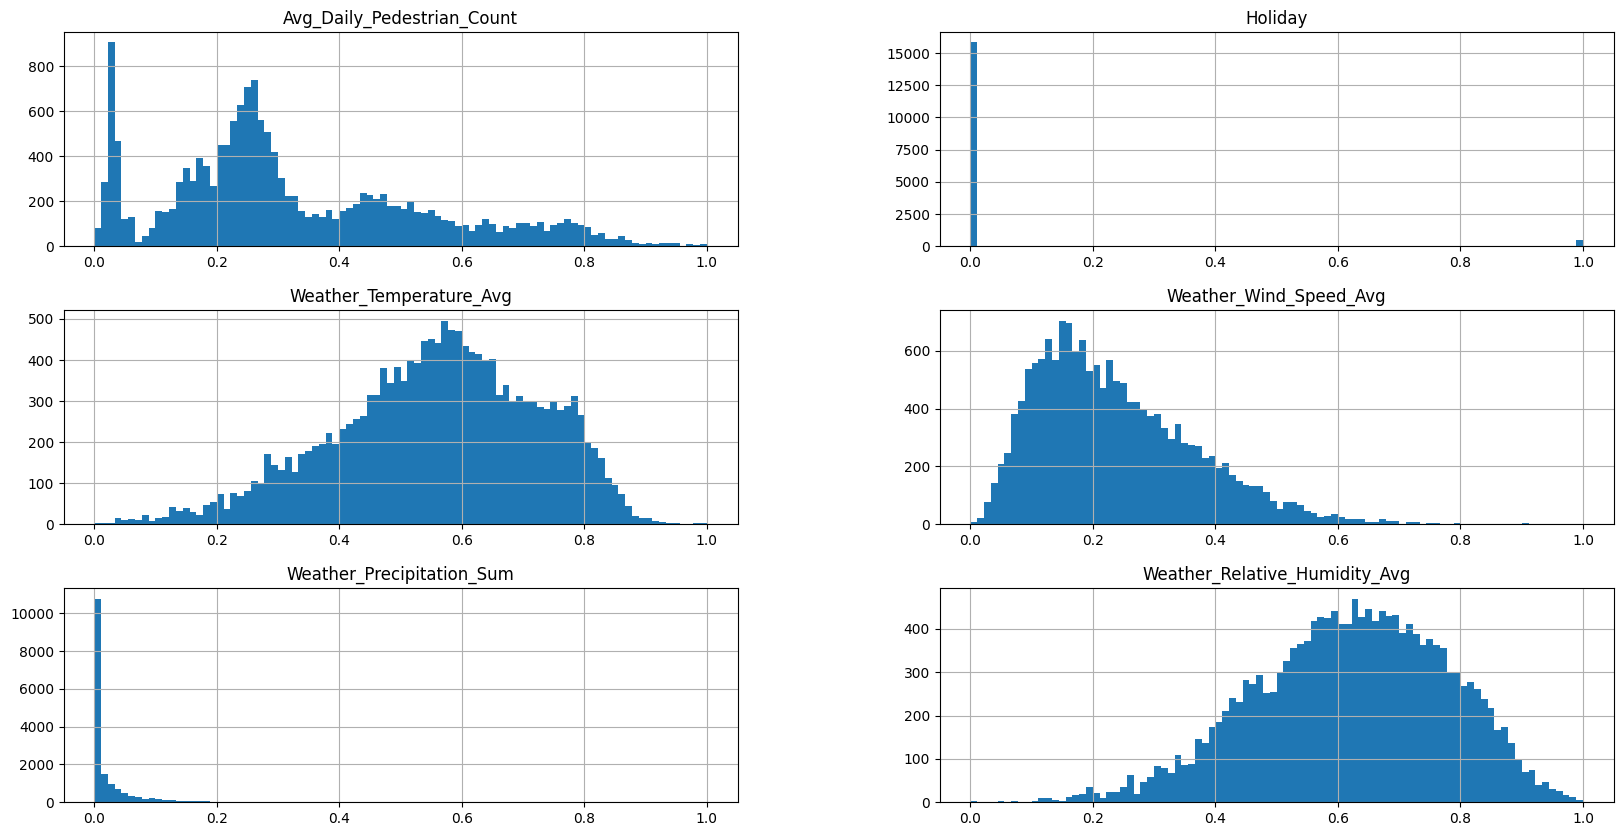

In [88]:
features = [cn for cn in dfle.columns.to_list() if cn not in ['Avg_Daily_Pedestrian_Count','Location_ID','Date']]
targets = ['Avg_Daily_Pedestrian_Count']
scaler = MinMaxScaler()
dfFScl = dfle.copy()
dfFScl[features + targets] = scaler.fit_transform(dfFScl[features + targets])
display(dfFScl.describe(include='all').T.round(3))
display(dfFScl.iloc[:,2:8].hist(figsize=(20,10),bins=90))

### Creating Sequences for the LSTM model

In [89]:
def create_sequences(df, features, targets, seq_len):
    X,y = [], []
    for loc in df['Location_ID'].unique():
        sub = df[df['Location_ID'] == loc].sort_values('Date')
        feat_values = sub[features].values
        target_values = sub[targets].values
        for i in range(seq_len, len(sub)):
            X.append(feat_values[i-seq_len:i])
            y.append(target_values[i])
    return np.array(X), np.array(y)
SEQ_LEN = 30
X, y = create_sequences(dfFScl, features, targets, SEQ_LEN)

### Split Train/Test data 

In [90]:
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
print('X_train:', X_train.shape, 'y_train:', y_train.shape)

X_train: (12836, 30, 15) y_train: (12836, 1)


### Creating the RNN/LSTM model

In [91]:
model = Sequential([
    Bidirectional(LSTM(96, return_sequences=True, input_shape=(SEQ_LEN, len(features)))),
    Dropout(0.1),
    LSTM(32, return_sequences=False),
    Dropout(0.1),
    Dense(12, activation='linear'),
    Dense(1, activation='linear')])
optimizer = Adam(learning_rate=0.01) #0.001,0.01
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

c:\Users\athar\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Test the model

In [92]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)
history = model.fit(X_train, y_train, validation_split=0.2, epochs=40, batch_size=64, callbacks=[early_stop, lr_scheduler], verbose=1)

Epoch 1/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - loss: 0.0665 - mae: 0.1316 - val_loss: 0.0476 - val_mae: 0.1750 - learning_rate: 0.0100
Epoch 2/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 0.0111 - mae: 0.0740 - val_loss: 0.0347 - val_mae: 0.1521 - learning_rate: 0.0100
Epoch 3/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 0.0106 - mae: 0.0704 - val_loss: 0.0432 - val_mae: 0.1701 - learning_rate: 0.0100
Epoch 4/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 0.0101 - mae: 0.0679 - val_loss: 0.0464 - val_mae: 0.1758 - learning_rate: 0.0100
Epoch 5/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - loss: 0.0110 - mae: 0.0744 - val_loss: 0.0447 - val_mae: 0.1730 - learning_rate: 0.0100
Epoch 6/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 0.0098 - mae: 0.0667 - val_loss: 0.0557 - val_mae: 0.1908 - learning_rate: 0.0100
Epoch 7/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 10s 59ms/step - loss: 0.0102 - mae: 0.0680 - val_loss: 0.0452 - val_mae: 0.1743 - learning_rate:

### Eval the model

In [95]:
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse:.4f}') # 0.1017
print(f'MAE : {mae:.4f}') # 0.0773
print(f'R²   : {r2:.4f}') # 0.6500

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
RMSE: 0.2057
MAE : 0.1711
R²   : -0.1122


#### Attempts: 30 Seq length
-   RMSE 0.1156 MAE 0.0877 R2 0.6453 | LR 0.05 | LSTM BI 96,DO 0.3,LSTM 64,DO 0.3,Dense 24(32) relu,Dense 1 linear
-   RMSE 0.1137 MAE 0.0863 R2 0.6568 | LR 0.05 | LSTM BI 96,DO 0.3,LSTM 64,DO 0.3,Dense 24(32) linear,Dense 1 linear
-   RMSE 0.1103 MAE 0.0828 R2 0.6768 | LR 0.05 | LSTM BI 96,DO 0.3,LSTM 64,DO 0.1(0.3),Dense 24(32) linear,Dense 1 linear
-   RMSE 0.0974 MAE 0.0709 R2 0.7482 | LR 0.05 | LSTM BI 96,DO 0.2(0.3),LSTM 64,DO 0.1(0.3),Dense 24(32) linear,Dense 1 linear
-   RMSE 0.1049 MAE 0.0799 R2 0.7079 | LR 0.05 | LSTM BI 124(96),DO 0.2(0.3),LSTM 64,DO 0.1(0.3),Dense 24(32) linear,Dense 1 linear
-   RMSE 0.1072 MAE 0.0789 R2 0.6949 | LR 0.05 | LSTM BI 86(124)(96),DO 0.2(0.3),LSTM 54(64),DO 0.1(0.3),Dense 24(32) linear,Dense 1 linear
-   RMSE 0.0970 MAE 0.0725 R2 0.7501 | LR 0.05 | LSTM BI 96(86)(124)(96),DO 0.1(0.2)(0.3),LSTM 64(54)(64),DO 0.05(0.1)(0.3),Dense 24(32) linear,Dense 1 linear 
-   RMSE 0.1097 MAE 0.0834 R2 0.6807 | LR 0.05 | LSTM BI 96(86)(124)(96),DO 0.1(0.2)(0.3),LSTM 64(54)(64),DO 0.05(0.1)(0.3),Dense 32(24)(32) linear,Dense 1 linear
-   RMSE 0.1033 MAE 0.0758 R2 0.7168 | LR 0.05 | LSTM BI 96(86)(124)(96),DO 0.1(0.2)(0.3),LSTM 64(54)(64),DO 0.05(0.1)(0.3),Dense 24(32)(24)(32) linear,Dense 1 linear
-   RMSE 0.1255 MAE 0.0958 R2 0.5816 | LR 0.05 | LSTM BI 96(86)(124)(96),DO 0.05(0.1)(0.2)(0.3),LSTM 64(54)(64),DO 0.05(0.1)(0.3),Dense 24(32)(24)(32) linear,Dense 1 linear
-   RMSE 0.1148 MAE 0.0866 R2 0.6501 | LR 0.05 | LSTM BI 96(86)(124)(96),DO 0.15(0.05)(0.1)(0.2)(0.3),LSTM 64(54)(64),DO 0.05(0.1)(0.3),Dense 24(32)(24)(32) linear,Dense 1 linear
-   RMSE 0.1170 MAE 0.0905 R2 0.6366 | LR 0.05 | LSTM BI 96(86)(124)(96),DO 0.15(0.05)(0.1)(0.2)(0.3),LSTM 64(54)(64),DO 0.1(0.05)(0.1)(0.3),Dense 24(32)(24)(32) linear,Dense 1 linear
-   RMSE 0.1025 MAE 0.0779 R2 0.7208 | LR 0.05 | LSTM BI 96(86)(124)(96),DO 0.5(0.15)(0.05)(0.1)(0.2)(0.3),LSTM 64(54)(64),DO 0.3(0.1)(0.05)(0.1)(0.3),Dense 24(32)(24)(32) linear,Dense 1 linear
-   RMSE 0.1058 MAE 0.0777 R2 0.7028 | LR 0.05 | LSTM BI 96(86)(124)(96),DO 0.5(0.15)(0.05)(0.1)(0.2)(0.3),LSTM 64(54)(64),DO 0.4(0.3)(0.1)(0.05)(0.1)(0.3),Dense 24(32)(24)(32) linear,Dense 1 linear

#### Attempts: 60 Seq length
-   RMSE 0.1187 MAE 0.0898 R2 0.6131 | LR 0.05 | LSTM BI 96(86)(124)(96),DO 0.5(0.15)(0.05)(0.1)(0.2)(0.3),LSTM 64(54)(64),DO 0.4(0.3)(0.1)(0.05)(0.1)(0.3),Dense 24(32)(24)(32) linear,Dense 1 linear   
-   RMSE 0.0984 MAE 0.0718 R2 0.7344 | LR 0.05 | LSTM BI 128(96)(86)(124)(96),DO 0.2(0.5)(0.15)(0.05)(0.1)(0.2)(0.3),LSTM 64(54)(64),DO 0.2(0.4)(0.3)(0.1)(0.05)(0.1)(0.3),Dense 24(32)(24)(32) linear,Dense 1 linear   
-   RMSE 0.1084 MAE 0.0812 R2 0.6772 | LR 0.05 | LSTM BI 128(96)(86)(124)(96),DO 0.2(0.5)(0.15)(0.05)(0.1)(0.2)(0.3),LSTM 64(54)(64),DO 0.2(0.4)(0.3)(0.1)(0.05)(0.1)(0.3),Dense 24(32)(24)(32) relu,Dense 1 linear  
-   RMSE 0.0983 MAE 0.0722 R2 0.7347 | LR 0.05 | LSTM BI 128(96)(86)(124)(96),DO 0.2(0.5)(0.15)(0.05)(0.1)(0.2)(0.3),LSTM 84(64)(54)(64),DO 0.2(0.4)(0.3)(0.1)(0.05)(0.1)(0.3),Dense 24(32)(24)(32) linear,Dense 1 linear  

### Attempts: 60 Seq length, removed attraction_score column
-   RMSE 0.0938 MAE 0.0690 R2 0.7583 | LR 0.05 | LSTM BI 128(96)(86)(124)(96),DO 0.2(0.5)(0.15)(0.05)(0.1)(0.2)(0.3),LSTM 84(64)(54)(64),DO 0.2(0.4)(0.3)(0.1)(0.05)(0.1)(0.3),Dense 24(32)(24)(32) linear,Dense 1 linear <--

### Attempts: 60 Seq length, removed attraction_score & Weather_Precipitation_Avg column     
-   RMSE 0.1107 MAE 0.0833 R2 0.6636 | LR 0.05 | LSTM BI 128(96)(86)(124)(96),DO 0.2(0.5)(0.15)(0.05)(0.1)(0.2)(0.3),LSTM 84(64)(54)(64),DO 0.2(0.4)(0.3)(0.1)(0.05)(0.1)(0.3),Dense 24(32)(24)(32) linear,Dense 1 linear

### Attempts: 60 Seq length, removed attraction_score column
-   RMSE 0.1028 MAE 0.0780 R2 0.7098 | LR 0.05 | LSTM BI 128(96)(86)(124)(96),DO 0.2(0.5)(0.15)(0.05)(0.1)(0.2)(0.3),LSTM 84(64)(54)(64),DO 0.2(0.4)(0.3)(0.1)(0.05)(0.1)(0.3),Dense 24(32)(24)(32) linear,Dense 1 linear

### Attempts: 60 Seq length, removed attraction_score column & removed bi directional from model
-   RMSE 0.0985 MAE 0.0735 R2 0.7337 | LR 0.05 | LSTM 128(96)(86)(124)(96),DO 0.2(0.5)(0.15)(0.05)(0.1)(0.2)(0.3),LSTM 84(64)(54)(64),DO 0.2(0.4)(0.3)(0.1)(0.05)(0.1)(0.3),Dense 24(32)(24)(32) linear,Dense 1 linear

### Attempts: 60 Seq length, removed attraction_score cloumn
-   RMSE 0.0969 MAE 0.0725 R2 0.7424 | LR 0.05 | LSTM 54(128)(96)(86)(124)(96),DO 0.2(0.5)(0.15)(0.05)(0.1)(0.2)(0.3),LSTM 24(84)(64)(54)(64),DO 0.1(0.2)(0.4)(0.3)(0.1)(0.05)(0.1)(0.3),Dense 12(24)(32)(24)(32) linear,Dense 1 linear

### Attempts: 60 Seq length, re addded Bi-drectional to LSTM model
-   RMSE 0.0950 MAE 0.0692 R2 0.7523 | LR 0.05 | LSTM BI 54(128)(96)(86)(124)(96),DO 0.2(0.5)(0.15)(0.05)(0.1)(0.2)(0.3),LSTM 24(84)(64)(54)(64),DO 0.1(0.2)(0.4)(0.3)(0.1)(0.05)(0.1)(0.3),Dense 12(24)(32)(24)(32) linear,Dense 1 linear

### Attempts: 90 Seq length
-   RMSE 0.1014 MAE 0.0758 R2 0.7067 | LR 0.05 | LSTM BI 84,DO 0.3,LSTM 42,DO 0.3,Dense 21 linear,Dense 1 linear

### Plotting the results of Predicited vs Actual

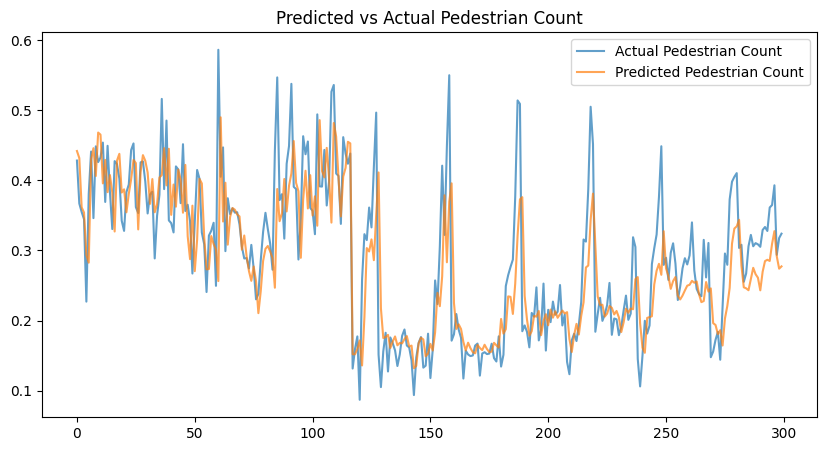

In [56]:
plt.figure(figsize=(10,5))
plt.plot(y_test[:300,0], label='Actual Pedestrian Count', alpha=0.7)
plt.plot(y_pred[:300,0], label='Predicted Pedestrian Count', alpha=0.7)
plt.legend()
plt.title('Predicted vs Actual Pedestrian Count')
plt.show()

### Saving the model

In [ ]:
model.save('Output Charts/1optimized_lstm_tourism_model.h5')
import joblib
joblib.dump(scaler, 'Output Charts/1scaler.pkl')
print('Model and scaler saved successfully.')